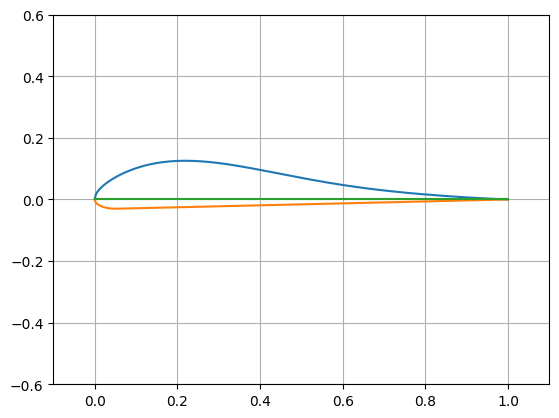

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from utils.generafoil import elliptique_rounded, curve_from_cst

NB_POINTS = 400

x = np.linspace(0, 1, NB_POINTS)

#Example of some coefficients that could be used to create profile
b = 0.03
a = 0.05
A = [0.3, 0.5, 0.2, 0.1, 0.1, 0.05]

y_low, alpha = elliptique_rounded(x, a, b)
y_up = curve_from_cst(x, A)

#Plot the profile
plt.plot(x, y_up)
plt.plot(x, y_low)
plt.plot(x, np.zeros(len(x)))
plt.ylim((-0.6, 0.6))
plt.xlim((-0.1, 1.1))
plt.grid()

In [8]:
from utils.optimize import converence_contrain

thickness = 0.14
flat_lenght = 0.7
reynolds = 5e5
nb_test = 10

result = converence_contrain(x, thickness, flat_lenght, reynolds, nb_test)
print(result)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.020803851887408
            Iterations: 24
            Function evaluations: 250
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.87334198968795e-06
            Iterations: 5
            Function evaluations: 40
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.708905986699984e-05
            Iterations: 2
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.944020265646006e-10
            Iterations: 2
            Function evaluations: 16
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.433505126503479e-06
            Iterations: 3
            Functi

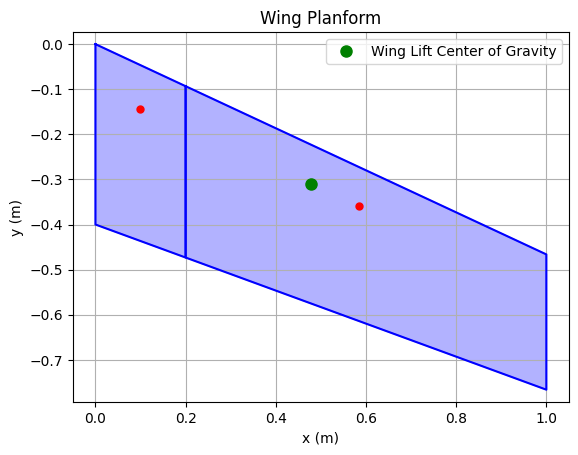

([{'cl': np.float64(-3.874069784897663), 'cd': np.float64(1.494494999388219), 'cm': np.float64(-0.3499278442332606), 'alpha_neutral': np.float64(-0.7697201479545991), 'surface': np.float64(0.07800000000000001), 'lift_center': (np.float64(0.09914529914529915), np.float64(-0.14375357978288877)), 'mac_length': np.float64(0.3900854700854701), 'lift': np.float64(-74.03347358939435), 'drag': np.float64(28.559799438308875), 'moment': np.float64(-2.608548779098317)}, {'cl': np.float64(-3.945508397562563), 'cd': np.float64(1.536161459622223), 'cm': np.float64(-0.36042690672182087), 'alpha_neutral': np.float64(-0.7697201479545991), 'surface': np.float64(0.27199999999999996), 'lift_center': (np.float64(0.584313725490196), np.float64(-0.3578621218239011)), 'mac_length': np.float64(0.34156862745098043), 'lift': np.float64(-262.9286796135692), 'drag': np.float64(102.36979966922493), 'moment': np.float64(-8.204085307722984)}], (np.float64(0.47771806322726557), np.float64(-0.3108206397411661)))


In [9]:
from utils.optimize import lift_data
flat_lenght = 0.7


#result = [4.16235673e-02, 2.23000744e-02, 3.23611543e-01, 3.49532240e-01, 7.32004212e-13, 1.40671958e-12, 5.97061122e-13]
wing_params = [flat_lenght] + result


profiles = [{
    'params': wing_params,
    "x_root": 0,
},
{
    'params': wing_params,
    "x_root": 0.2,
}
]

print(lift_data(0.4, 1, 25, 0.25, profiles, 20))

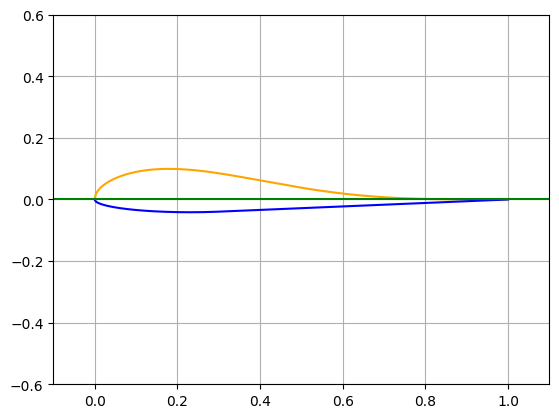

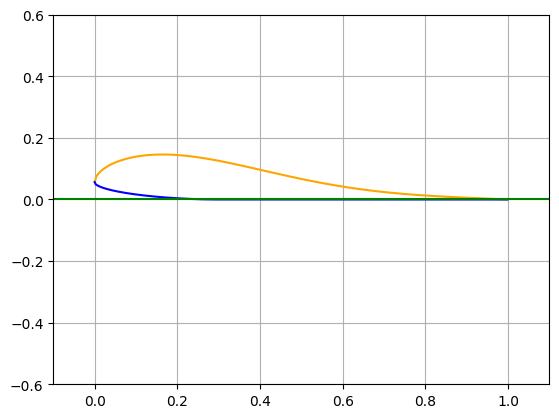

In [10]:
from utils.generafoil import plot_foil

a = (1 - flat_lenght)/(2 - flat_lenght)
b = result[0]

cst_coefficients = result[2:]

y_up = curve_from_cst(x, cst_coefficients)
y_low, alpha = elliptique_rounded(x, a, b)

plot_foil(x, y_up, y_low, 0)
plot_foil(x, y_up, y_low, alpha)

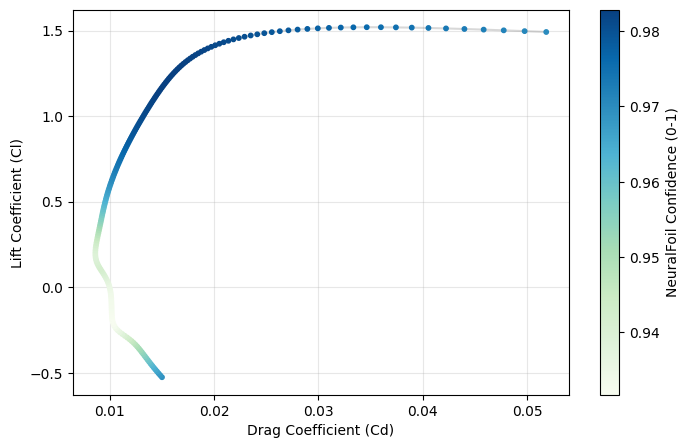

In [ ]:
import aerosandbox as asb

upper_coords = np.array([x[::-1], y_up[::-1]]).T

# 2. Keep the lower surface from LE (x=0) to TE (x=1)
# We skip the first point [1:] to avoid duplicating the Leading Edge point (0,0)
lower_coords = np.array([x[1:], y_low[1:]]).T

# 3. Stack them into one continuous array
coord = np.concatenate([upper_coords, lower_coords], axis=0)

speed = 20  # m/s
reynolds_number = speed * 0.4 / (1.56e-5)  # Re = V * c / nu, nu = 1.56e-5 m2/s (kinematic viscosity of air at 15C)
mach_number = speed / 340  # Approximate speed of sound at sea level in m/s

airfoil = asb.Airfoil("Custom", coordinates=np.array(coord)).repanel(n_points_per_side=100)

aero = airfoil.get_aero_from_neuralfoil(
    alpha=np.linspace(-5, 15, 200),
    Re=reynolds_number,
    mach=mach_number,
    include_360_deg_effects=True
)

cd = aero["CD"]
cl = aero["CL"]
conf = aero["analysis_confidence"]

plt.figure(figsize=(8, 5))

# Create the scatter plot where color (c) is determined by confidence
sc = plt.scatter(cd, cl, c=conf, cmap="GnBu", s=10, zorder=3)

# Add a thin line to connect the dots for visual clarity
plt.plot(cd, cl, color="gray", alpha=0.3, zorder=2)

# Add a colorbar to show what the colors mean
cbar = plt.colorbar(sc)
cbar.set_label("NeuralFoil Confidence (0-1)")

plt.xlabel("Drag Coefficient (Cd)")
plt.ylabel("Lift Coefficient (Cl)")
plt.grid(True, alpha=0.3)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

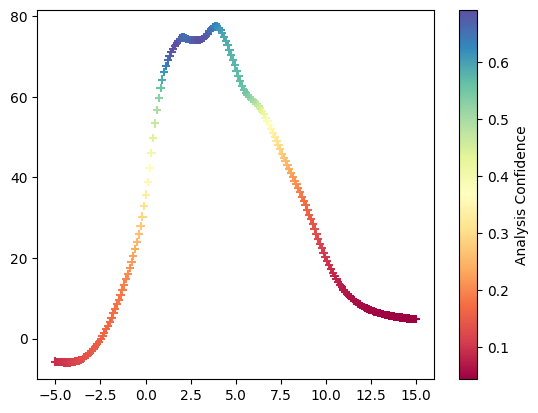

In [ ]:


flap = asb.ControlSurface(
    name="Flap",
    hinge_point=0.75,
    deflection=10
)

# You can also use the helper method to get a flapped airfoil geometry
flapped_airfoil = airfoil.add_control_surface(
    hinge_point_x=0.75,
    deflection=10
)

plt.scatter(
    np.linspace(-5, 15, 200),
    aero['CL']/aero['CD'],
    c=aero['analysis_confidence'], 
    cmap='Spectral',               
    label='Données Aérodynamiques',
    marker='+'
)
plt.colorbar(label="Analysis Confidence")
#plot vertical bar at alpha
plt.axvline(x=np.linspace(-5, 15, 200), color='r', linestyle='--', label='Angle de calage')
plt.xlabel('Angle d\'attaque (°)')
plt.ylabel('CL/CD')
plt.show()

dict_keys(['analysis_confidence', 'CL', 'CD', 'CM', 'Top_Xtr', 'Bot_Xtr', 'upper_bl_theta_0', 'upper_bl_theta_1', 'upper_bl_theta_2', 'upper_bl_theta_3', 'upper_bl_theta_4', 'upper_bl_theta_5', 'upper_bl_theta_6', 'upper_bl_theta_7', 'upper_bl_theta_8', 'upper_bl_theta_9', 'upper_bl_theta_10', 'upper_bl_theta_11', 'upper_bl_theta_12', 'upper_bl_theta_13', 'upper_bl_theta_14', 'upper_bl_theta_15', 'upper_bl_theta_16', 'upper_bl_theta_17', 'upper_bl_theta_18', 'upper_bl_theta_19', 'upper_bl_theta_20', 'upper_bl_theta_21', 'upper_bl_theta_22', 'upper_bl_theta_23', 'upper_bl_theta_24', 'upper_bl_theta_25', 'upper_bl_theta_26', 'upper_bl_theta_27', 'upper_bl_theta_28', 'upper_bl_theta_29', 'upper_bl_theta_30', 'upper_bl_theta_31', 'upper_bl_H_0', 'upper_bl_H_1', 'upper_bl_H_2', 'upper_bl_H_3', 'upper_bl_H_4', 'upper_bl_H_5', 'upper_bl_H_6', 'upper_bl_H_7', 'upper_bl_H_8', 'upper_bl_H_9', 'upper_bl_H_10', 'upper_bl_H_11', 'upper_bl_H_12', 'upper_bl_H_13', 'upper_bl_H_14', 'upper_bl_H_15', 'u

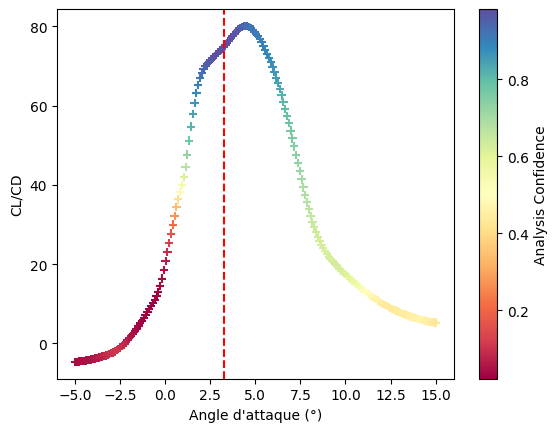

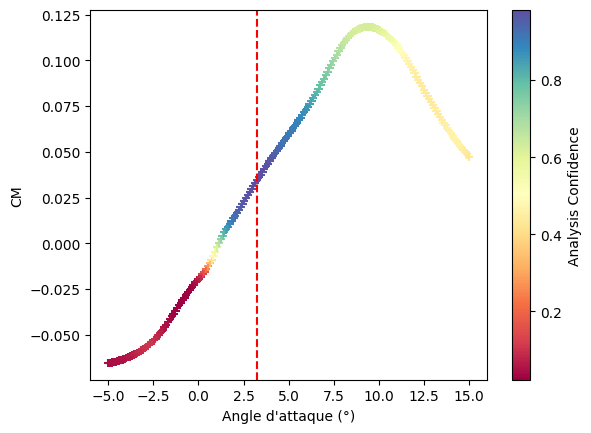

In [ ]:
import neuralfoil as nf



aero = nf.get_aero_from_coordinates(  # You can use xy airfoil coordinates as an entry point
    coordinates=np.array(coord), 
    alpha=np.linspace(-5, 15, 200),  # Vectorize your evaluations across `alpha` and `Re`
    Re=5e5,
    model_size='xxxlarge'
)

print(aero.keys())

alpha_degree = -alpha * 180 / np.pi

plt.scatter(
    np.linspace(-5, 15, 200),
    aero['CL']/aero['CD'],
    c=aero['analysis_confidence'], 
    cmap='Spectral',               
    label='Données Aérodynamiques',
    marker='+'
)
plt.colorbar(label="Analysis Confidence")
#plot vertical bar at alpha
plt.axvline(x=alpha_degree, color='r', linestyle='--', label='Angle de calage')
plt.xlabel('Angle d\'attaque (°)')
plt.ylabel('CL/CD')
plt.show()

# Plotting CM
plt.scatter(
    np.linspace(-5, 15, 200),
    aero['CM'],
    c=aero['analysis_confidence'], 
    cmap='Spectral',               
    label='Données Aérodynamiques',
    marker='+'
)

plt.axvline(x=alpha_degree, color='r', linestyle='--', label='Angle de calage')
plt.xlabel('Angle d\'attaque (°)')
plt.ylabel('CM')
plt.colorbar(label="Analysis Confidence")
plt.show()